
# Medical Named Entity Recognition with BERT

This code is inspired in the following resources:

https://github.com/Spain-AI/transformers
(by Álvaro Barbero)

https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/ (by Tobias Sterbak)


In [1]:
pip install transformers==2.9

In [1]:
import torch
import numpy as np
import pandas as pd

In [4]:
# Import data 
# Use "quoting=3" to avoid error when pandas interpretates the quotation character as a quotation passage
train = pd.read_csv("abstracts-eudract-train.sent",sep="\t",engine="python",quoting=3)
print(len(train))
train.tail()

208188


,Sentence #,Token,Tag
208183,12554,que,O
208184,12554,requieren,O
208185,12554,oxígeno,B-PROC
208186,12554,domiciliario,I-PROC
208187,12554,.,O


In [2]:
dev = pd.read_csv("abstracts-eudract-dev.sent",sep="\t",engine="python",quoting=3)
print(len(dev))
dev.tail()

69319


,Sentence #,Token,Tag
69314,4549,próximas,O
69315,4549,24,O
69316,4549,-,O
69317,4549,48,O
69318,4549,horas,O


In [5]:
test = pd.read_csv("abstracts-eudract-test.sent",sep="\t",engine="python",quoting=3)

In [6]:
print(len(test))
test.tail()

68994


,Sentence #,Token,Tag
68989,4504,D,I-CHEM
68990,4504,.,O
68991,4505,-,O
68992,4505,Mujeres,O
68993,4505,embarazadas,O


In [9]:
class ProcessSentences(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Token"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [10]:
sentences_data_train = ProcessSentences(train)
sentences_data_dev = ProcessSentences(dev)
sentences_data_test = ProcessSentences(test)

In [11]:
sentences_train = [[word[0] for word in sentence] for sentence in sentences_data_train.sentences]
sentences_dev = [[word[0] for word in sentence] for sentence in sentences_data_dev.sentences]
sentences_test = [[word[0] for word in sentence] for sentence in sentences_data_test.sentences]
sentences_dev[0][:10] # First 10 elements of sentence 1

['Efectos',
 'del',
 'trandolapril',
 'en',
 'monoterapia',
 'y',
 'asociado',
 'con',
 'verapamil',
 ',']

In [12]:
# Show labels
labels_train = [[s[1] for s in sentence] for sentence in sentences_data_train.sentences]
labels_dev = [[s[1] for s in sentence] for sentence in sentences_data_dev.sentences]
labels_test = [[s[1] for s in sentence] for sentence in sentences_data_test.sentences]
print(labels_dev[0][:10]) # First 10 labels of sentence 1


['O', 'O', 'B-CHEM', 'O', 'B-PROC', 'O', 'O', 'O', 'B-CHEM', 'O']


In [11]:
# Label values
tag_values = list(set(train["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}


In [12]:
## Prepare data for BERT
# Import pytorch and transformers library
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import transformers
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences

torch.__version__

'1.6.0+cu101'

In [13]:
# Measure length of sentences to know which is the maximum length we can use
lenghts_train = [len(sentence) for sentence in sentences_data_train.sentences]
lenghts_dev = [len(sentence) for sentence in sentences_data_dev.sentences]
lenghts_test = [len(sentence) for sentence in sentences_data_test.sentences]

In [14]:
# use the numpy function quantile to obtain a length in which 90% of the sentences can fit
maxlength_train = int(np.quantile(lenghts_train, 0.9))
maxlength_dev = int(np.quantile(lenghts_dev, 0.9))
maxlength_test = int(np.quantile(lenghts_test, 0.9))
print(maxlength_train)
print(maxlength_dev)
print(maxlength_test)

37
35
36


In [15]:
# Define BERT parameters
# Sentence length
MAX_LEN = 37
# Batch size
bs = 32 

In [16]:
# CUDA device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
# Print state of GPU
!nvidia-smi

Fri Aug  7 16:01:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
# Import BERT tokenizer
# Use the BETO model (BERT for Spanish), available in the Transformers library  
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', do_lower_case=False)

In [18]:
# Function to tokenize and preserve labels
def tokenize_and_keep_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize each word and count number of its subwords
        # We force conversion to string to avoid errors with float elements
        tokenized_word = tokenizer.tokenize(str(word))
        n_subwords = len(tokenized_word)

        # The tokenized word is added to the resulting tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # The same label is added to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [19]:
tokenized_texts_and_labels_train = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_train, labels_train)
]

In [20]:
tokenized_texts_and_labels_dev = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_dev, labels_dev)
]

In [21]:
tokenized_texts_and_labels_test = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_test, labels_test)
]

In [22]:
tokenized_texts_train = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_train]
labels_train = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_train]

tokenized_texts_dev = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_dev]
labels_dev = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_dev]

tokenized_texts_test = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_test]
labels_test = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_test]

In [23]:
# Padding of sentences according to desired input length
input_ids_train = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_train],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

input_ids_dev = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_dev],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

input_ids_test = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_test],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [24]:
# Paddding of labels with regard to input length
tags_train = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_train],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

tags_dev = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_dev],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

tags_test = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_test],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


In [25]:
# Create the attention mask to ignore the padded elements in the sequences during training, development and testing
attention_masks_train = [[float(i != 0.0) for i in ii] for ii in input_ids_train]
attention_masks_dev = [[float(i != 0.0) for i in ii] for ii in input_ids_dev]
attention_masks_test = [[float(i != 0.0) for i in ii] for ii in input_ids_test]

In [26]:
# Convert the dataset to torch tensors
train_inputs = torch.tensor(input_ids_train)
dev_inputs = torch.tensor(input_ids_dev)
test_inputs = torch.tensor(input_ids_test)
train_tags = torch.tensor(tags_train)
dev_tags = torch.tensor(tags_dev)
test_tags = torch.tensor(tags_test)
train_masks = torch.tensor(attention_masks_train)
dev_masks = torch.tensor(attention_masks_dev)
test_masks = torch.tensor(attention_masks_test)

In [27]:
# We define the dataloaders. 
# Shuffle the data for training using RandomSampler
train_data = TensorDataset(train_inputs, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

# Load dev and test data sequentially with SequentialSampler.
dev_data = TensorDataset(dev_inputs, dev_masks, dev_tags)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=bs)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

**Setting up the BERT model for the task**

In [28]:
# The BertForTokenClassification class is used for token-level predictions. 
# It includes the BERT model and carries out token-level classification in the last layer
# We use the Adam optimizer
from transformers import BertForTokenClassification, AdamW 

In [43]:
# Instantiate the model and use the pretrained BETO model (BERT for Spanish)
model = BertForTokenClassification.from_pretrained(
    "dccuchile/bert-base-spanish-wwm-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


In [44]:
# Load the model to the GPU
model.cuda();

In [45]:
# weight_decay is a regularization procedure with regard to the weight matrices
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

# Adam optimizer
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [46]:
# Import a scheduler to reduce the learning rate 
from transformers import get_linear_schedule_with_warmup

# Number of training epochs; the BERT paper uses 4
epochs = 4
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [33]:
# Import modules to measure the progression of training
!pip install seqeval

In [34]:
import seqeval
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

In [47]:
# Train the model for; the BERT paper uses 4
## Store the average loss after each epoch; these values are used to plot the loss.
loss_values, development_loss_values = [], []

for _ in range(epochs):
    #
    # Training
    #
    # Set the model into training mode
    model.train()
    # Reset the total loss for each epoch
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        # Transfer batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Remove previous gradients before each backward pass
        model.zero_grad()
        # forward pass
        # This returns the loss (not the model output) since we have input the labels.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # Get the loss
        loss = outputs[0]
        # Backward pass to compute the gradients
        loss.backward()
        # Train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # Update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    

    # Store each loss value for plotting the learning curve afterwards
    loss_values.append(avg_train_loss)

    # After each training epoch, measure performance on development set

    # Set the model into evaluation mode
    model.eval()
    # Reset the development loss for this epoch
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in dev_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # The model must not compute or save gradients, in order to save memory and speed up this step
        with torch.no_grad():
            # Forward pass, compute predictions
            # This will return the logits (logarithm of the odds), not the loss (we do not provide labels)
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Transfer logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Compute the accuracy for this batch of development sentences
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(dev_dataloader)
    development_loss_values.append(eval_loss)
    print("Development loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    dev_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Development Accuracy: {}".format(accuracy_score(pred_tags, dev_tags)))
    print("Development classification report:\n{}".format(classification_report(pred_tags, dev_tags,digits=4)))
    print()


Average train loss: 0.3592839899825989
Development loss: 0.23189702244488508
Development Accuracy: 0.9224301770902821
Development classification report:
           precision    recall  f1-score   support

     PROC     0.7786    0.7471    0.7625      5733
     DISO     0.8947    0.7985    0.8438      5404
     CHEM     0.9358    0.8356    0.8829      4695
     ANAT     0.4979    0.4799    0.4888       498

micro avg     0.8509    0.7814    0.8147     16330
macro avg     0.8537    0.7814    0.8157     16330


Average train loss: 0.15086602703988097
Development loss: 0.21396676732318384
Development Accuracy: 0.9312406388843438
Development classification report:
           precision    recall  f1-score   support

     PROC     0.8233    0.7565    0.7885      5987
     ANAT     0.5687    0.5291    0.5482       516
     DISO     0.9030    0.8292    0.8645      5252
     CHEM     0.9015    0.9283    0.9147      4071

micro avg     0.8626    0.8174    0.8394     15826
macro avg     0.8616    

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


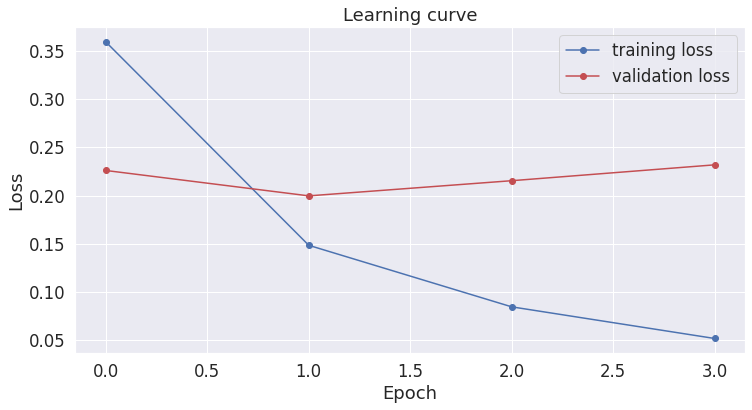

In [36]:
# Plot the training loss
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(development_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [41]:
# Apply the model to the test set
# Set again the model into evaluation mode
model.eval()
nb_eval_steps, nb_eval_examples = 0, 0
predictions , true_labels = [], []

for batch in test_dataloader:

    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # The model must not compute or store gradients
    with torch.no_grad():
        # Forward pass, calculate predictions.
        outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
    # Transfer logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences
    eval_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
test_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
print("Test Accuracy: {}".format(accuracy_score(pred_tags, test_tags),digits=4))
print("Test classification report: {}".format(classification_report(pred_tags, test_tags,digits=4)))
print()


Test Accuracy: 0.9389523736482859
Test classification report:            precision    recall  f1-score   support

     PROC     0.8455    0.7740    0.8082      5541
     DISO     0.8880    0.8814    0.8847      4883
     CHEM     0.9129    0.9063    0.9096      4014
     ANAT     0.5570    0.5919    0.5739       446

micro avg     0.8690    0.8395    0.8540     14884
macro avg     0.8690    0.8395    0.8536     14884




In [38]:
# Save labels predicted by system and reference labels
with open("labels_test_ref","w") as f:
    for label in test_tags:
        print("token\t" + label,file=f)
with open("labels_test_hyp","w") as f:
    for label in pred_tags:
        print("token\t" + label,file=f)

In [39]:
model.save_pretrained('.')